# Assignment 3 - Using Stan & other exercises

In [39]:
# Setup 
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pystan

## 1. Implement models in Stan

### 1. Call center data set

To model the call center data set we use Bayesian inference. To calculate the posterior we use an exponential likelihood with a gamma prior. We want to estimat the number of calls per minute for the 13th hour of the call center data set.

In [2]:
# Load the data set containing durations between calls arriving at the call
# center during 1 day. All values are in minutes.
waiting_times_day = np.loadtxt('call-center.csv')

# Display some basic information about the data set.
print('Size of data set:', len(waiting_times_day))
print('First 3 values in data set:', waiting_times_day[:3])
print('Sum of data set:', sum(waiting_times_day))

Size of data set: 5856
First 3 values in data set: [30.   3.4  3.2]
Sum of data set: 1441.6838153800093


To remind ourselves let's look at the distribution of the waiting times per hour.

In [3]:
# Make 24 empty lists, one per hour.
waiting_times_per_hour = [[] for _ in range(24)]

# Split the data into 24 separate series, one for each hour of the day.
current_time = 0
for t in waiting_times_day:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)

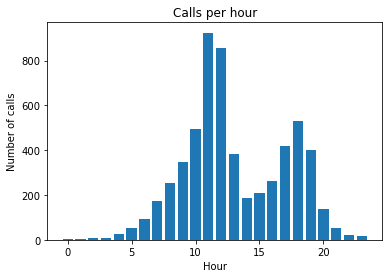

In [4]:
plt.bar(
    x = list(range(len(waiting_times_per_hour))), 
    height = [len(x) for x in waiting_times_per_hour]
)
plt.xlabel('Hour')
plt.ylabel('Number of calls')
plt.title('Calls per hour')
plt.show()

Specifically looking at the 13th hour, we can see the distribtuion of the waiting times of the 13th hour.

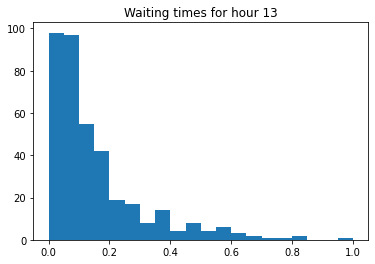

In [5]:
# Plot histogram of waiting times for hour
hour_index = 13
waiting_times_hour = waiting_times_per_hour[hour_index]
plt.hist(waiting_times_hour, bins=20)
plt.title('Waiting times for hour %i' % hour_index)
plt.show()

In [6]:
stan_code = '''

data {
    int <lower=1> N;   // Sample size
    vector[N] y;       // Outcome
    real alpha;        // Prior hyperparameter
    real beta;         // Prior hyperparameter
}

parameters {
    real lambda;  // the parameter for our posterior model
}

model {
    lambda ~ gamma(alpha, beta);     // Prior distribution
    y ~ exponential(lambda);         // Likelihood distribution
}
'''

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1207905c5bb1a40fd000b1255d75927c NOW.


In [7]:
# Results for one row (father = 0)
stan_data = {
    'N': len(waiting_times_hour),
    'y': waiting_times_hour,
    'alpha': 1,
    'beta': 0.25
}
results = stan_model.sampling(data=stan_data)
print(results)

Inference for Stan model: anon_model_1207905c5bb1a40fd000b1255d75927c.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda   6.36  8.1e-3   0.33   5.73   6.15   6.36   6.58   7.04   1653    1.0
lp__   322.56    0.02   0.74 320.45 322.42 322.86 323.02 323.08   1821    1.0

Samples were drawn using NUTS at Thu Feb 18 17:47:00 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [8]:
# The 98% percentiles
samples = results.extract()
np.percentile(samples['lambda'], [1, 99])

array([5.63365285, 7.17951561])

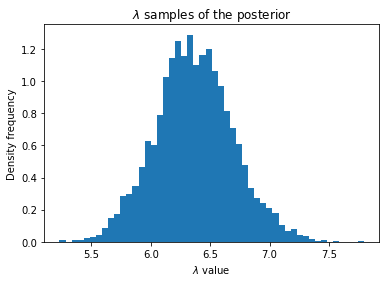

In [20]:
plt.hist(samples['lambda'], bins=50, density=True)
plt.title('$\lambda$ samples of the posterior')
plt.xlabel('$\lambda$ value')
plt.ylabel('Density frequency')
plt.show()

### 2. Normal likelihood with normal-inverse-gamma prior.

200 data


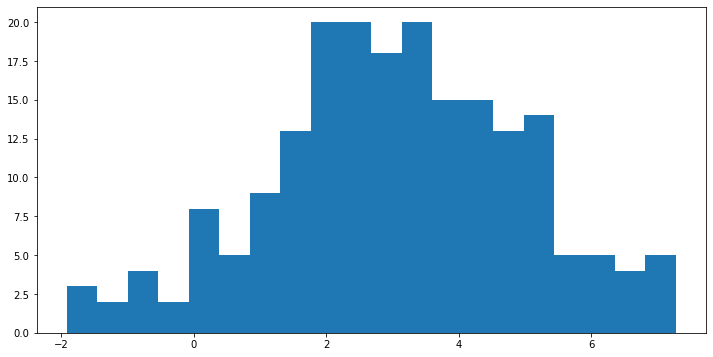

Data sample mean: 3.065080189542003
Data sample variance: 3.6152141787699223


In [21]:
data = np.array([3.54551763569501, 4.23799861761927, 4.72138425951628, -0.692265320368236, 3.04473513808788, 3.10721270732507, 3.42982225852764, 3.12153903971176, 3.60532628639808, 2.46561737557325, 1.64059465916131, 2.4621623937158, 2.76744495617481, 2.11580054750407, 5.14077208608354, 4.90288499104252, 1.43357579078348, 4.78997817363558, 1.93633438207439, 2.43698838097178, 3.95389148701877, 2.4242295507716, 2.90256268679023, 2.90931728045901, 0.658072819386888, 3.05946763895983, 3.42615331539605, 2.68842833004417, 2.35850130765166, 2.20014998540933, 4.73846511350084, 4.19839721414451, 2.11805510171691, -0.572742936038015, 0.389413982010623, 3.87846130744249, 1.34057656890858, 0.7235748351719, 5.11042369840174, 4.00747556696571, 3.18080956726965, 3.24677964069676, 5.1154659863626, 1.80276616697155, 0.305877679021404, -0.449168307882718, 4.63705561194774, 1.37783714058301, 4.9608149859515, 6.7764195802069, 1.75515522922399, 7.04457337435215, 0.625185284955128, 2.25130734369064, 2.19770178119255, 2.16858257249432, 6.25367644481438, 0.116081323476489, 2.06315857864341, 1.82409781471718, 5.15226741230987, 2.03408231293173, -1.12450854337596, 5.03511270642234, 2.03841989653263, 5.80911741751597, 2.31718128783245, 4.97575010580997, 3.34262752222776, -0.786983904253601, 0.777362359850013, 0.975825009321195, 3.76354577515958, 7.27215002907876, 1.35404089480189, 3.76567940257157, 3.48573993343334, 1.85976988586156, 1.93567061960716, 5.31071812003942, 2.96832987672751, 3.32378908637275, 2.61631960054551, 5.80897964052825, 4.95215217171488, 1.32036772796131, 3.79932542233371, 3.08108492766309, 2.6734110081666, -0.14251851138521, 2.48744375588965, 3.98463042123415, 6.32781680028, 4.0029172024315, 4.23210369459457, 1.71412938967325, 5.16492114963802, 2.53409673107906, 4.77346963973334, 3.34088878725551, 4.77681472750664, 3.81135755590976, 1.14054269983137, 1.42057452397702, 0.132142311125433, 7.12577254064672, 4.85422012781764, 4.15745720676399, 4.48763147363348, 1.56060322283629, 2.64821761542887, 1.26655351354548, 4.48497722937931, 4.3286302403783, 4.26157679512625, 4.0597558651364, 5.14051109132496, 2.5660348362221, 1.10764013818617, 0.386889523012303, 3.54150473246237, 3.57480214382351, 1.95150869584847, 2.70688970563118, 2.47971849820016, 6.50838037000679, 4.01511556826974, 1.11562740835344, 5.02637639472439, 4.38184491686864, 5.60423144047386, 2.40067408379298, 5.7849941378344, 2.37225791084559, 6.86031465910273, 4.09214858239736, 6.85994063692621, 3.62202415158781, -1.11220646958158, 3.73920971696866, 3.24533871512216, 1.28724203643002, 0.291152541773164, 0.368630935755111, 6.71607270510525, 5.42278455200833, 5.35188416119281, 2.305874586163, -1.85878097203032, 2.69877382351447, 4.84121860550417, 4.40973060799391, 5.04399320650774, 2.68632252661298, 6.06531610659912, 3.11881325011993, 3.45532087005125, 3.08442259840346, 4.43564424136733, 2.84252623135804, 1.50536798885106, 1.48868622407603, 2.07322837615663, 2.5476910210998, 5.66941808257884, 2.16731067416426, 2.49843958833905, 3.94586413879977, 0.316433764679541, -0.608937441815983, 2.5943436558557, 1.05516869528337, 2.1447601332725, 6.65846634141906, 2.1771555267834, 5.23953812029442, 3.53629759842647, 6.03263538017003, 3.85739159396599, 5.95093453004638, 1.12856987160476, 3.5559912886093, 2.21974864244489, 3.38471394882135, -1.90805399279409, 3.5113699258973, 4.49319955412346, 5.10507952638867, 1.08277895384184, 4.58403638422759, 1.37304994426824, 4.17566975753523, 3.36454182510378, 0.177136582644021, 2.91337423388405, 3.22796455457526, 2.80124198378441, 1.95189718582788, 3.37659263896246, -1.6463045238231])
print(len(data), "data")

# Plot a histogram of the data. Do the data look normally distributed?
plt.figure(figsize=(12, 6))
plt.hist(data, bins=20)
plt.show()

# Calculate the sample mean and variance of the data
print('Data sample mean:', np.mean(data))
print('Data sample variance:', np.var(data))

In [25]:
stan_code = '''

data {
    int <lower=1> N;   
    vector[N] y;       
    real<lower=0> mu_0; 
    real nu_0;
    real alpha_0;
    real beta_0;        
}

parameters {
    real x;         // the parameter for our posterior model
    real sigma;     // the parameter for our posterior model
}

model {
    sigma ~ inv_gamma(alpha_0, beta_0);
    x ~ normal(mu_0, sqrt(sigma / nu_0));  // Normal-inverse-Gamma prior
    
    y ~ normal(x, sqrt(sigma));            // Likelihood distribution
}
'''

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_038c36e6a9a5672d4d54f0fdfc202679 NOW.


In [26]:
# Results for one row (father = 0)
stan_data = {
    'N': len(data),
    'y': data,
    'mu_0': 0,
    'nu_0': 0.054,
    'alpha_0': 1.12,
    'beta_0': 0.4
}
results = stan_model.sampling(data=stan_data)
print(results)

Inference for Stan model: anon_model_038c36e6a9a5672d4d54f0fdfc202679.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
x       3.06  2.4e-3   0.13    2.8   2.97   3.07   3.15   3.32   3211    1.0
sigma   3.62  7.0e-3   0.37   2.98   3.36    3.6   3.85   4.41   2761    1.0
lp__  -234.5    0.02   1.03 -237.2 -234.9 -234.2 -233.7 -233.5   1703    1.0

Samples were drawn using NUTS at Thu Feb 18 20:15:46 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [28]:
samples = results.extract()
samples

OrderedDict([('x',
              array([3.0832683 , 3.02303922, 2.96356082, ..., 2.76726749, 2.82097969,
                     3.22418279])),
             ('sigma',
              array([3.1929173 , 4.32791328, 3.17212863, ..., 2.67654149, 3.41109822,
                     3.65952788])),
             ('lp__',
              array([-234.03661524, -235.52923488, -234.41804061, ..., -241.10213754,
                     -235.28857707, -234.25862175]))])

In [41]:
np.random.seed = 1
num_samples = 10
indexes = np.random.randint(len(samples['x']), size=num_samples)
indexes

array([3740, 3393, 3101, 2840, 3498,  809, 3988,  694, 3742, 1154])

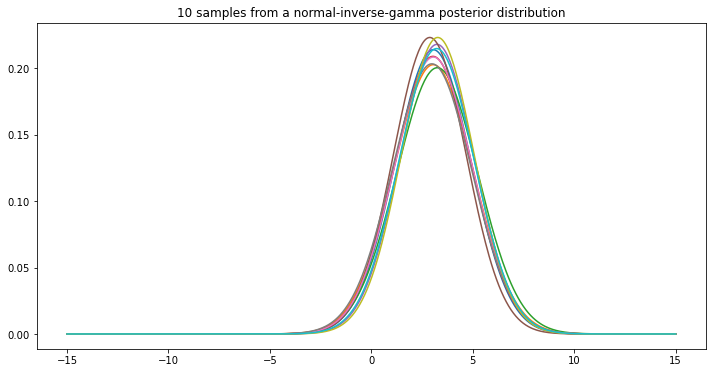

In [42]:
# Plot the normal distributions corresponding to the samples
plt.figure(figsize=(12, 6))
plot_x = np.linspace(-15, 15, 500)
for i in indexes:
    plot_y = stats.norm.pdf(
        plot_x, 
        loc=samples['x'][i], 
        scale=np.sqrt(samples['sigma'][i])
    )
    plt.plot(plot_x, plot_y)
plt.title('%i samples from a normal-inverse-gamma posterior distribution' % num_samples)
plt.show()

### 3. Log-normal HRTEM data

In [43]:
# Load data: read the particle sizes (in nanometers) from a CSV file.
data = np.loadtxt('hrtem.csv')
print('%i data, min: %f, max: %f' % (len(data), min(data), max(data)))

500 data, min: 1.051827, max: 28.942578


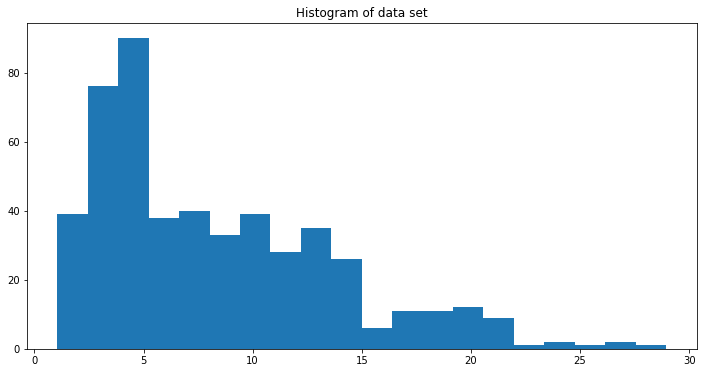

In [48]:
# Data are very skew and all values are positive, so probably non-normal.
plt.figure(figsize=(12,6))
plt.hist(data, bins=20)
plt.title('Histogram of data set')
plt.show()

In [49]:
stan_code = '''

data {
    int <lower=1> N;   
    vector[N] y;       
    real<lower=0> mu_0; 
    real nu_0;
    real alpha_0;
    real beta_0;        
}

parameters {
    real x;         // the parameter for our posterior model
    real sigma;     // the parameter for our posterior model
}

model {
    sigma ~ inv_gamma(alpha_0, beta_0);
    x ~ normal(mu_0, sqrt(sigma / nu_0));  // Normal-inverse-Gamma prior
    
    y ~ lognormal(x, sqrt(sigma));            // Likelihood distribution
}
'''

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bbe19295a9ae7b419d28246a49417bd3 NOW.


In [50]:
# Results for one row (father = 0)
stan_data = {
    'N': len(data),
    'y': data,
    'mu_0': 2.3,
    'nu_0': 0.1,
    'alpha_0': 2,
    'beta_0': 5
}
results = stan_model.sampling(data=stan_data)
print(results)

Inference for Stan model: anon_model_bbe19295a9ae7b419d28246a49417bd3.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
x       1.89  5.2e-4   0.03   1.83   1.87   1.89   1.91   1.95   3586    1.0
sigma    0.5  5.4e-4   0.03   0.44   0.47   0.49   0.52   0.56   3384    1.0
lp__   -75.3    0.02   0.99 -77.96 -75.69  -75.0 -74.59 -74.34   1835    1.0

Samples were drawn using NUTS at Thu Feb 18 21:04:11 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [52]:
samples = results.extract()
samples

OrderedDict([('x',
              array([1.88236396, 1.9194305 , 1.92442539, ..., 1.86351512, 1.85434324,
                     1.88371499])),
             ('sigma',
              array([0.50679154, 0.48381535, 0.51512496, ..., 0.45760694, 0.50969436,
                     0.55381262])),
             ('lp__',
              array([-74.48257642, -74.71116899, -75.09242777, ..., -75.40407961,
                     -75.19271386, -76.10882539]))])

In [51]:
np.random.seed = 1
num_samples = 10
indexes = np.random.randint(len(samples['x']), size=num_samples)
indexes

array([3289,  242, 1738, 2223,  999, 1519, 3795, 1293,  857, 3478])

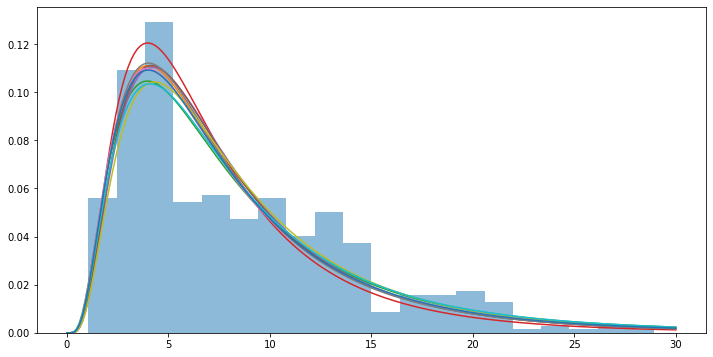

In [54]:
plt.figure(figsize=(12,6))
plt.hist(data, bins=20, density=True, alpha=0.5)
plot_x = np.linspace(0, 30, 200)
for i in indexes:
    plot_y = stats.lognorm.pdf(
        plot_x, 
        np.sqrt(samples['sigma'][i]), 
        scale=np.exp(samples['x'][i])
    )
    plt.plot(plot_x, plot_y)
plt.show()